In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$f_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta_i^\top x$$

# Generate Communication Network

In [2]:
n = 50  # Number of nodes
n_i = 1  # Number of informed nodes
print(f'{n} nodes, {n_i} informed')

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes (Change this to reflect supply chain structure)
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.random_tree(n)  # Generate graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in tqdm(G.nodes):
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

l_tr = np.sort(nx.laplacian_spectrum(G))[1]
print(f'lambda_2 = {np.sort(nx.laplacian_spectrum(G))[1]}')

50 nodes, 1 informed


100%|███████████████████████████████████████| 50/50 [00:00<00:00, 169535.33it/s]

lambda_2 = 0.010722918787478608



<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


/var/folders/1z/598c66r120j6wsq2k38rmm3h0000gn/T/ipykernel_16850/858935796.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


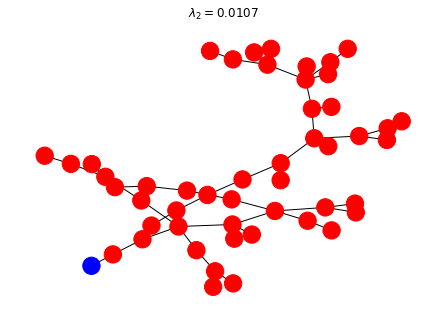

In [3]:
plt.figure()
colors = ['b' if inf else 'r' for inf in N]
nx.draw(G, node_color=colors)
plt.title(r'$\lambda_2 = $'+f'{np.sort(nx.laplacian_spectrum(G))[1].round(4)}')
plt.tight_layout()
plt.savefig('./figures/tree.png')
plt.show()

# Problem Parameters

In [4]:
np.random.seed(37)
theta_0 = (1/(n+3))*np.ones((n,n))-2*np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
xi_bar = n

# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return np.dot(theta+theta.T,x) + xi

# CVXPY solution

In [6]:
theta_s = 0.5*(theta+theta.T)
x = cp.Variable(n)
objective = cp.Maximize(cp.quad_form(x,theta_s)+(xi_bar*np.ones(n)@x))
constraints = [0 <= x, x <= n]
prob = cp.Problem(objective, constraints)

revenue_so = prob.solve()

x_so = x.value
print(x_so.round(2))
print(f'socially optimal total revenue: ${revenue_so.round(2)}')

[23.92 33.78 32.65 21.18 25.56 28.15  7.6  41.87 29.8  29.58 27.76 28.25
 25.39 30.88 29.06 12.28 37.77 36.11 22.87 18.67 35.39 10.88 32.24 33.81
 20.55 26.17 21.94 22.59 35.71 38.55 21.46 27.7  33.84 25.41 21.8   6.37
 38.23 31.17 41.23 19.28 27.7  25.88 22.18 17.9  33.94 25.23 28.21 18.3
 25.27 24.09]
socially optimal total revenue: $33403.0


# Optimization Parameters

In [7]:
step = 1e-2
alpha = 1-1e-3
iterations = 10000
p_max = n
window = iterations

# Distributed SGD with asynchronous information

In [8]:
np.random.seed(37)

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

rev_dist = []
rev_bar = []
x_dist_hist = []
x_bar_hist = []

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(np.mean(X.copy(),axis=0))
    ma_len = min(window,len(x_dist_hist))
    x_bar_hist.append(np.mean(x_dist_hist[-ma_len:],axis=0))
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += (step*(alpha**i))*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_bar))
    rev_dist.append(sum(temp)/len(temp))
    rev_bar.append(np.mean(rev_dist[-ma_len:]))
    X = np.clip(X,0,p_max)

100%|████████████████████████████████████| 10000/10000 [00:17<00:00, 576.97it/s]


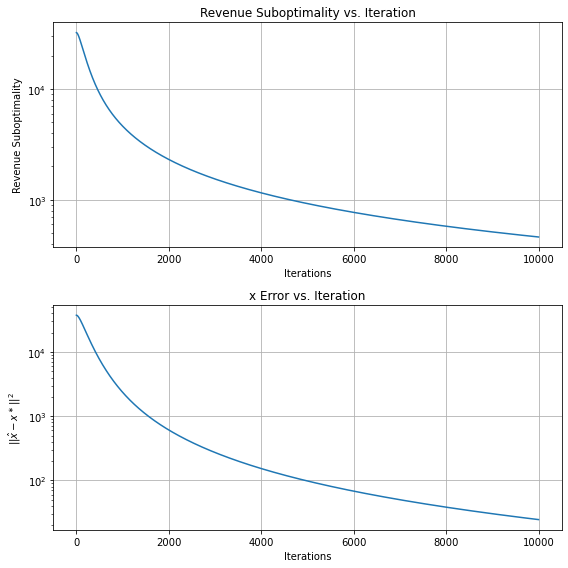

In [9]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
rev_err_tree = abs(revenue_so - rev_bar)
ax[0].semilogy(rev_err_tree)
ax[0].grid()
ax[0].set_title('Revenue Suboptimality vs. Iteration')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Revenue Suboptimality')
x_err_tree = la.norm(x_so - x_bar_hist, axis=1)**2
ax[1].semilogy(x_err_tree)
ax[1].grid()
ax[1].set_title('x Error vs. Iteration')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel(r'$||\hat{x}-x^\ast||^2$')

plt.tight_layout()
plt.savefig('./figures/dist_sgd_async.png')
plt.show()

In [10]:
print(f'x = {X[0].round(2)}')
print(f'x error = {(la.norm(x_so-np.mean(x_dist_hist[-1000:],axis=0))**2).round(5)}')
print(f'revenue = {rev_dist[-1].round(2)}')
print(f'revenue error = {abs(sum(rev_dist[-1000:])/1000-revenue_so).round(2)}')

x = [23.92 33.78 32.65 21.18 25.56 28.15  7.6  41.87 29.8  29.58 27.76 28.25
 25.39 30.88 29.06 12.28 37.77 36.11 22.87 18.67 35.39 10.88 32.24 33.81
 20.55 26.17 21.94 22.59 35.71 38.55 21.46 27.7  33.84 25.41 21.8   6.37
 38.23 31.16 41.23 19.28 27.69 25.88 22.18 17.9  33.94 25.23 28.21 18.3
 25.27 24.09]
x error = 3e-05
revenue = 33403.0
revenue error = 0.0


# Fully connected graph

lambda_2 = 49.99999999999987


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/var/folders/1z/598c66r120j6wsq2k38rmm3h0000gn/T/ipykernel_16850/541019694.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


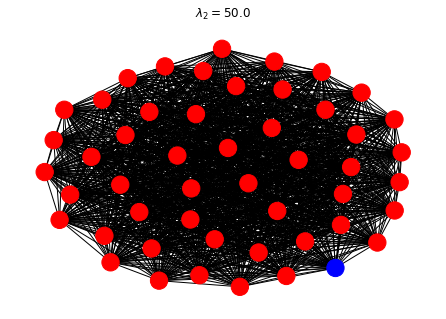

100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 343.51it/s]


In [11]:
np.random.seed(37)

G = nx.complete_graph(n)  # Generate complete graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

l_fc = np.sort(nx.laplacian_spectrum(G))[1]
print(f'lambda_2 = {np.sort(nx.laplacian_spectrum(G))[1]}')

plt.figure()
colors = ['b' if inf else 'r' for inf in N]
nx.draw(G, node_color=colors)
plt.title(r'$\lambda_2 = $'+f'{np.sort(nx.laplacian_spectrum(G))[1].round(4)}')
plt.tight_layout()
plt.savefig('./figures/complete.png')
plt.show()

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

rev_dist = []
rev_bar = []
x_dist_hist = []
x_bar_hist = []

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(np.mean(X.copy(),axis=0))
    ma_len = min(window,len(x_dist_hist))
    x_bar_hist.append(np.mean(x_dist_hist[-ma_len:],axis=0))
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += (step*(alpha**i))*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    rev_bar.append(np.mean(rev_dist[-ma_len:]))
    X = np.clip(X,0,p_max)

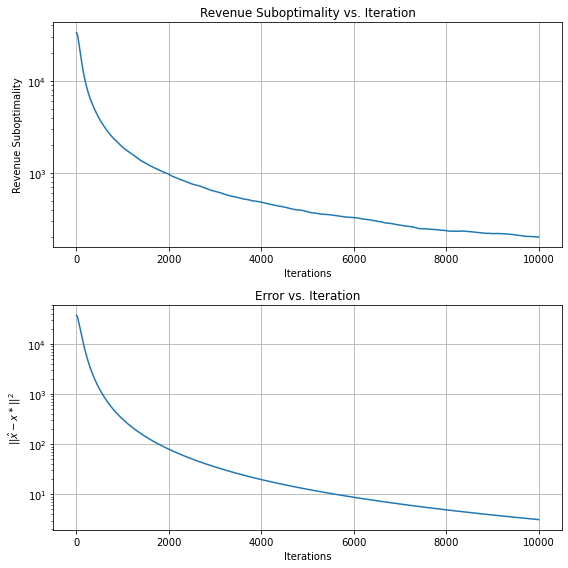

In [12]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
rev_err_fc = abs(revenue_so - rev_bar)
ax[0].semilogy(rev_err_fc)
ax[0].grid()
ax[0].set_title('Revenue Suboptimality vs. Iteration')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Revenue Suboptimality')
x_err_fc = la.norm(x_so - x_bar_hist, axis=1)**2
ax[1].semilogy(x_err_fc)
ax[1].grid()
ax[1].set_title('Error vs. Iteration')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel(r'$||\hat{x}-x^\ast||^2$')

plt.tight_layout()
plt.savefig('./figures/dist_sgd_fc.png')
plt.show()

In [13]:
print(f'x = {X[0].round(2)}')
print(f'x error = {(la.norm(x_so-np.mean(x_dist_hist[-1000:],axis=0))**2).round(5)}')
print(f'revenue = {rev_dist[-1].round(2)}')
print(f'revenue error = {abs(sum(rev_dist[-1000:])/1000-revenue_so).round(2)}')

x = [23.92 33.78 32.65 21.18 25.56 28.15  7.6  41.88 29.8  29.58 27.76 28.25
 25.39 30.88 29.06 12.28 37.77 36.12 22.87 18.67 35.39 10.88 32.24 33.81
 20.55 26.17 21.94 22.59 35.71 38.55 21.46 27.7  33.84 25.41 21.8   6.37
 38.23 31.17 41.23 19.28 27.7  25.88 22.18 17.9  33.95 25.23 28.21 18.3
 25.27 24.09]
x error = 9e-05
revenue = 33391.74
revenue error = 42.2


# Erdos Renyi random graph p=0.2

lambda_2 = 3.19332488181544


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/var/folders/1z/598c66r120j6wsq2k38rmm3h0000gn/T/ipykernel_16850/2102913908.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


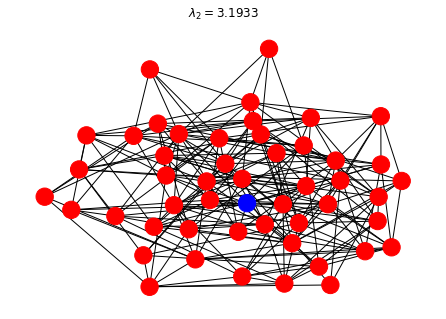

100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 493.61it/s]


In [14]:
np.random.seed(37)

G = nx.erdos_renyi_graph(n, p=0.2)  # Generate random graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

l_er = np.sort(nx.laplacian_spectrum(G))[1]
print(f'lambda_2 = {np.sort(nx.laplacian_spectrum(G))[1]}')

colors = ['b' if inf else 'r' for inf in N]
plt.figure()
nx.draw(G, node_color=colors)
plt.title(r'$\lambda_2 = $'+f'{np.sort(nx.laplacian_spectrum(G))[1].round(4)}')
plt.tight_layout()
plt.savefig('./figures/random.png')
plt.show()

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

rev_dist = []
rev_bar = []
x_dist_hist = []
x_bar_hist = []

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(np.mean(X.copy(),axis=0))
    ma_len = min(window,len(x_dist_hist))
    x_bar_hist.append(np.mean(x_dist_hist[-ma_len:],axis=0))
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += (step*(alpha**i))*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    rev_bar.append(np.mean(rev_dist[-ma_len:]))
    X = np.clip(X,0,p_max)

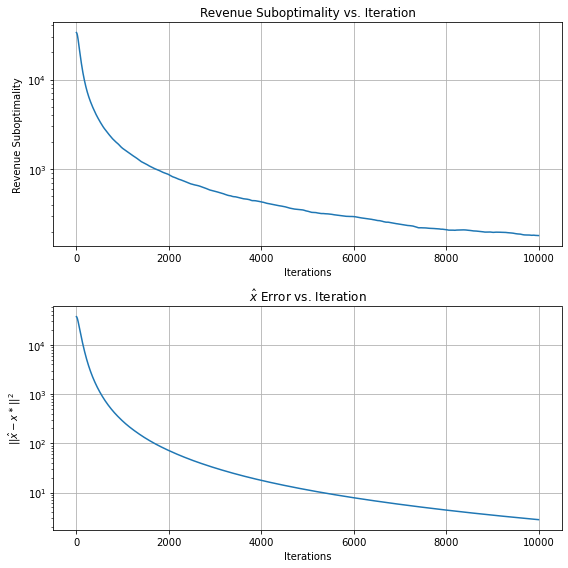

In [15]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
rev_err_er = abs(revenue_so - rev_bar)
ax[0].semilogy(rev_err_er)
ax[0].grid()
ax[0].set_title('Revenue Suboptimality vs. Iteration')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Revenue Suboptimality')
x_err_er = la.norm(x_so - x_bar_hist, axis=1)**2
ax[1].semilogy(x_err_er)
ax[1].grid()
ax[1].set_title(r'$\hat{x}$ Error vs. Iteration')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel(r'$||\hat{x}-x^\ast||^2$')

plt.tight_layout()
plt.savefig('./figures/dist_sgd_expander.png')
plt.show()

In [16]:
print(f'x = {X[0].round(2)}')
print(f'x error = {(la.norm(x_so-np.mean(x_dist_hist[-1000:],axis=0))**2).round(5)}')
print(f'revenue = {rev_dist[-1].round(2)}')
print(f'revenue error = {abs(sum(rev_dist[-1000:])/1000-revenue_so).round(2)}')

x = [23.92 33.78 32.65 21.18 25.56 28.15  7.6  41.88 29.8  29.58 27.76 28.25
 25.39 30.88 29.06 12.28 37.77 36.12 22.87 18.67 35.39 10.88 32.24 33.81
 20.55 26.17 21.94 22.59 35.71 38.55 21.46 27.7  33.84 25.41 21.8   6.37
 38.23 31.17 41.23 19.28 27.7  25.88 22.18 17.9  33.95 25.23 28.21 18.3
 25.27 24.09]
x error = 9e-05
revenue = 33407.62
revenue error = 43.0


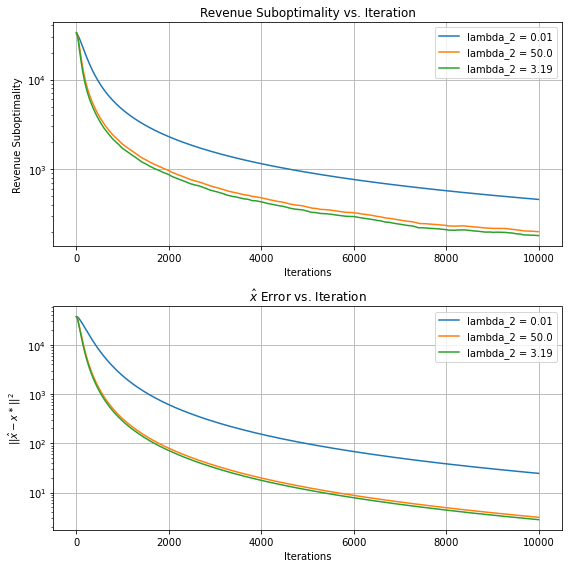

In [17]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
rev_dist_err = abs(revenue_so - rev_bar)
ax[0].semilogy(rev_err_tree,label=f'lambda_2 = {l_tr.round(2)}')
ax[0].semilogy(rev_err_fc,label=f'lambda_2 = {l_fc.round(2)}')
ax[0].semilogy(rev_err_er,label=f'lambda_2 = {l_er.round(2)}')
ax[0].grid()
ax[0].legend()
ax[0].set_title('Revenue Suboptimality vs. Iteration')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Revenue Suboptimality')
x_dist_err = la.norm(x_so - x_bar_hist, axis=1)**2
ax[1].semilogy(x_err_tree,label=f'lambda_2 = {l_tr.round(2)}')
ax[1].semilogy(x_err_fc,label=f'lambda_2 = {l_fc.round(2)}')
ax[1].semilogy(x_err_er,label=f'lambda_2 = {l_er.round(2)}')
ax[1].grid()
ax[1].legend()
ax[1].set_title(r'$\hat{x}$ Error vs. Iteration')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel(r'$||\hat{x}-x^\ast||^2$')

plt.tight_layout()
plt.savefig('./figures/graph_conv_comp.png')
plt.show()